In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [113]:
def clplot(X,labels,title,plt1,i):
    pltN=plt1[ int(i/3),  i%3 ]
    pltN.scatter(X[:,0],X[:,1], c = labels, cmap=plt.cm.spectral)
    pltN.set_title(title)
    pltN.axis('equal')
    pltN.axis('off')

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [5]:
data1 = pd.read_csv("dataset1.csv", sep='\t')
X = data1[['F1','F2']].get_values()
y = data1['T'].get_values()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
print (X_train.shape)
print (X_test.shape)

(804, 2)
(396, 2)


In [97]:
def stack_pred(estimator, X, y, Xt, k=3, method='predict'):
    kf = KFold(n_splits=k, random_state=0)
    t = 0.5 #порог
    
    if method == 'predict_proba':
        sX = np.zeros((X.shape[0], 2))
    elif method == 'predict':
        sX = np.zeros(X.shape[0]) 
    else:
        raise Exception('Error method')
    m_sX = np.zeros((k, (Xt.shape[0])))
    i = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        estimator.fit(X_train,y_train)
    
        if method == 'predict_proba':
            pred = estimator.predict_proba(X_test)
            pred2 = estimator.predict_proba(Xt)[:,1]
        else:
            pred = estimator.predict(X_test)
            pred2 = estimator.predict(Xt)
        sX[test_index] = pred
        m_sX[i] = pred2
        i += 1
    if method == 'predict_proba':
        sXt = np.vstack((1 - m_sX.mean(axis = 0),m_sX.mean(axis = 0))).T
    else:
        sXt = (m_sX.mean(axis = 0) > t).astype(int)
    return sX, sXt

In [102]:
estimator = KNeighborsClassifier()
sX, sXt = stack_pred(estimator=estimator, X=X_train, y=y_train, Xt=X_test,method='predict')
sXp, sXtp = stack_pred(estimator=estimator, X=X_train, y=y_train, Xt=X_test,method='predict_proba')

In [90]:
from sklearn import metrics 

In [103]:
print(metrics.classification_report(y_train, sX, digits=4), metrics.classification_report(y_test, sXt, digits=4))

             precision    recall  f1-score   support

          0     0.8808    0.8577    0.8691       267
          1     0.9301    0.9423    0.9362       537

avg / total     0.9137    0.9142    0.9139       804
              precision    recall  f1-score   support

          0     0.8788    0.8529    0.8657       136
          1     0.9242    0.9385    0.9313       260

avg / total     0.9086    0.9091    0.9088       396



In [105]:
metrics.roc_auc_score(y_train, sX), metrics.roc_auc_score(y_test, sXt)

(0.89997489172054479, 0.89570135746606327)

In [106]:
metrics.roc_auc_score(y_train, sXp[:,1]), metrics.roc_auc_score(y_test, sXtp[:,1])

(0.96965036720858699, 0.97307692307692306)

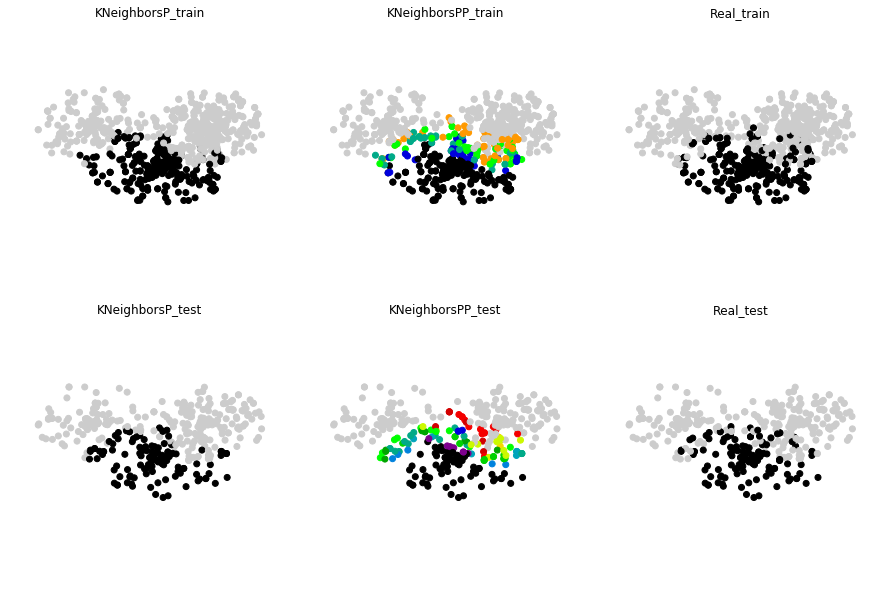

In [115]:
fig, axis = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
i = 0
clplot(X_train, sX,'KNeighborsP_train',axis,i);i+=1
clplot(X_train, sXp[:,1],'KNeighborsPP_train',axis,i);i+=1
clplot(X_train, y_train,'Real_train',axis,i);i+=1

clplot(X_test, sXt,'KNeighborsP_test',axis,i);i+=1
clplot(X_test, sXtp[:,1],'KNeighborsPP_test',axis,i);i+=1
clplot(X_test, y_test,'Real_test',axis,i);i+=1